# Garbage Classification with Pytorch

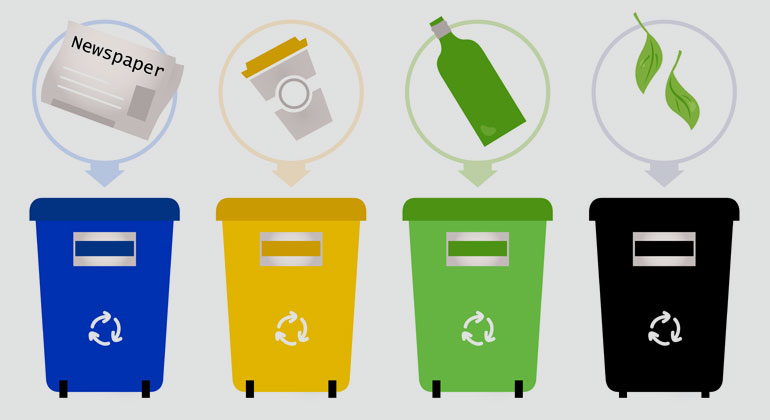






In this exercise, we will develop a multi-class model that can classify 6 different types of garbages. 

The dataset can be downloaded from https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?resource=download

🪲 Let's start! 



---



---



In [287]:
device = 'cuda'

# Data Upload 

In [288]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [289]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [290]:
data_dir = '/content/drive/MyDrive/딥러닝/Garbage classification'

In [291]:
import os 

classes = os.listdir(data_dir)
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

First, we check the size of images. For each class lets see 2 random images.

-------------cardboard-------------


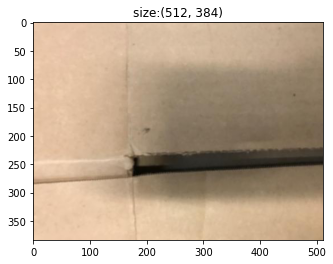

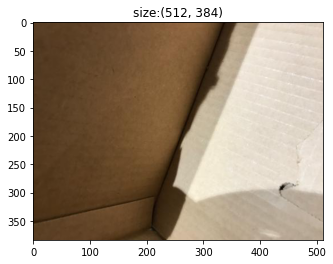

-------------glass-------------


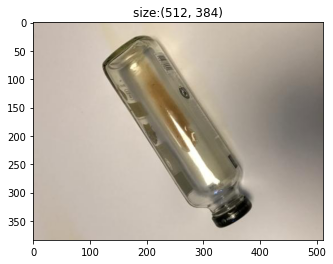

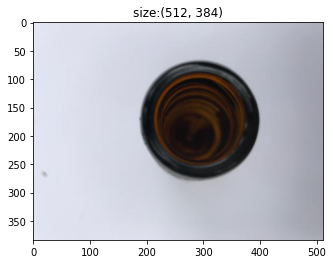

-------------metal-------------


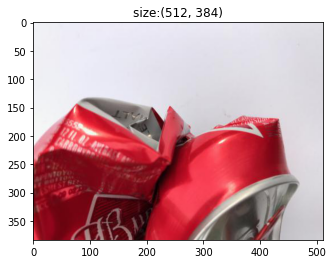

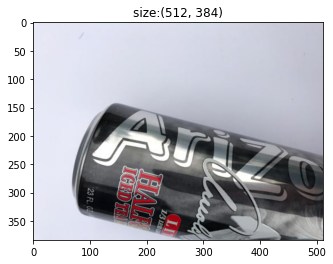

-------------paper-------------


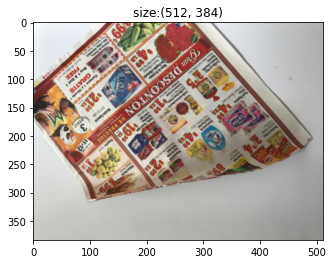

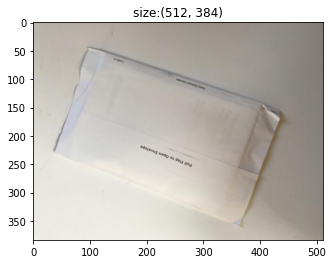

-------------plastic-------------


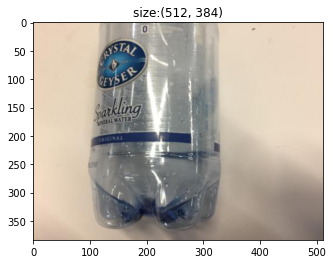

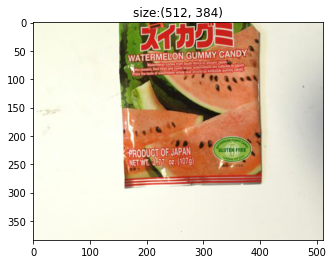

-------------trash-------------


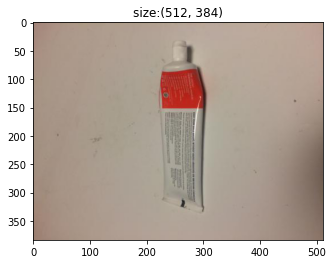

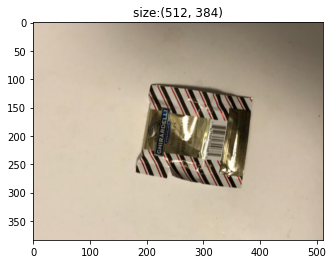

In [292]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from glob import glob

for cl in classes:
  print(f'-------------{cl}-------------')
  image_path = data_dir + '/' + cl + '/'
  image_paths = glob(os.path.join(image_path,  '*'))
  for _ in range(2):
    idx = np.random.randint(0, len(image_paths))
    image = Image.open(image_paths[idx])
    plt.imshow(image)
    plt.title(f'size:{image.size}')
    plt.show() 

The result above shows us that every image has the same size. The size is smaller than I have thought, but it doesnt bother. Still, we need to resize them so that they can fit into a certain model. 

Here, I will try using the pretrained model, ImageNet.

Now it is time to do some transformation! 
- Resize into 225 x 224 
- transform image to tensor 

In [293]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

Torchvision offers useful ImageFolder for uploading classification dataset. 


> To use ImageFoler, the structure of data directory must look like this! 

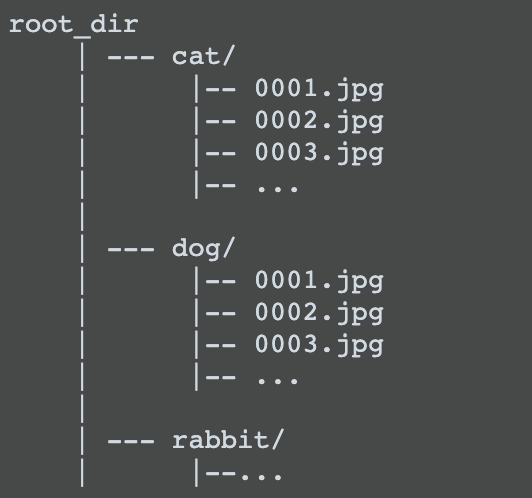

In [294]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# We apple our transformations using ImageFolder
dataset = ImageFolder(data_dir, transform = transformations)

In [295]:
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/MyDrive/딥러닝/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

# Split dataset

To train a model, we need to split our dataset to 
- train set
- validation set
- test set

In [296]:
len(dataset)

2527

In [297]:
train_ratio = int(len(dataset)*0.6)
val_ratio = int(len(dataset)*0.1)
test_ratio = int(len(dataset)*0.3)+1

In [298]:
train_ratio+val_ratio+test_ratio

2527

We will use random_split to split our dataset with our desired ratio.

In [299]:
from torch.utils.data import random_split

train_ds, val_ds, test_ds = random_split(dataset, [train_ratio,val_ratio,test_ratio])
len(train_ds), len(val_ds), len(test_ds)

(1516, 252, 759)

Lets check our train dataset!

In [300]:
tr_values = [item[1] for item in train_ds]

In [301]:
from collections import Counter

Counter(tr_values)

Counter({2: 238, 1: 302, 4: 292, 3: 349, 5: 95, 0: 240})

In our training dataset, the ratio of classes seems okay except class 5, which has only 83 in the dataset.

# Data augmentation (Data Transform)

- Train data
- Validation data

I refered to this page in order to do data augmentation after we splitted the datset. 

https://stackoverflow.com/questions/56582246/correct-data-loading-splitting-and-augmentation-in-pytorch



In [302]:
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch/54460259#54460259

In [303]:
from torchvision.transforms.transforms import RandomVerticalFlip
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAutocontrast(),
        transforms.RandomGrayscale(),
        #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.RandomVerticalFlip(0.5)])

In [304]:
train_ds = ApplyTransform(train_ds, transform=data_transforms)
val_ds = ApplyTransform(val_ds, transform=data_transforms)

In [305]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

We will use DataLoader to create batches.

In [306]:
train_loader = DataLoader(train_ds,
                            batch_size,
                            num_workers = 4,
                            shuffle=True)
val_loader = DataLoader(val_ds,
                         batch_size,
                         num_workers = 4,
                        shuffle=True)

test_loader = DataLoader(test_ds,
                        batch_size,
                        shuffle=False)

In [307]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

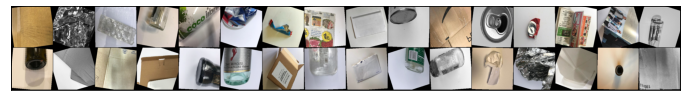

In [308]:
show_batch(val_loader)

# Model preparation

In [309]:
def train(model, trainLoader):
    model.to(device)
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [310]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [311]:
# Use pretrained GoogLeNet
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet = googlenet.to(device)

In [312]:
# To check summary of model
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [313]:
summary(googlenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

put parameter device in the fc layer to place in GPU as well.

In [317]:
googlenet.fc = nn.Linear(1024, 6, device=device)

In [318]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(googlenet.parameters(), lr=1e-3)

# Train model

In [319]:
N_EPOCH = 15

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(googlenet, train_loader )
    val_loss, val_accuracy = test(googlenet, test_loader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

EPOCH 1
     Train | Loss :  0.9265, Accuracy :  66.89 %
Validation | Loss :  0.6092, Accuracy :  80.63 %

EPOCH 2
     Train | Loss :  0.4846, Accuracy :  85.49 %
Validation | Loss :  0.4539, Accuracy :  85.24 %

EPOCH 3
     Train | Loss :  0.3688, Accuracy :  88.13 %
Validation | Loss :  0.3831, Accuracy :  87.88 %

EPOCH 4
     Train | Loss :  0.2923, Accuracy :  91.29 %
Validation | Loss :  0.3425, Accuracy :  88.54 %

EPOCH 5
     Train | Loss :  0.2320, Accuracy :  92.88 %
Validation | Loss :  0.3247, Accuracy :  89.46 %

EPOCH 6
     Train | Loss :  0.2042, Accuracy :  94.33 %
Validation | Loss :  0.3010, Accuracy :  90.38 %

EPOCH 7
     Train | Loss :  0.1797, Accuracy :  94.39 %
Validation | Loss :  0.3332, Accuracy :  88.27 %

EPOCH 8
     Train | Loss :  0.1506, Accuracy :  95.45 %
Validation | Loss :  0.3221, Accuracy :  89.59 %

EPOCH 9
     Train | Loss :  0.1382, Accuracy :  96.50 %
Validation | Loss :  0.3073, Accuracy :  90.12 %

EPOCH 10
     Train | Loss :  0.1369,

# Test model

In [322]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [336]:
True_cnt = 0
False_cnt = 0

for i in range(len(test_ds)):
  img, label = test_ds[i]
  if dataset.classes[label] == predict_image(img, googlenet):
    True_cnt += 1
  else:
    False_cnt += 1

print(f'Model was able to classify {True_cnt} images correctly!')
print(f'Model was wrong {False_cnt} times.')

Model was able to classify 695 images correctly!
Model was wrong 64 times.


In [341]:
print(f'{round((False_cnt/(False_cnt+True_cnt))*100)}% of total test dataset were classified wrong.')

8% of total test dataset were classified wrong.


 8% is not quite bad but there is definitely a space for improvement. More experiments coming! 

Label: metal , Predicted: metal


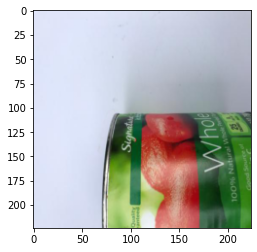

Label: plastic , Predicted: plastic


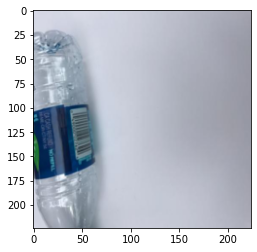

Label: cardboard , Predicted: cardboard


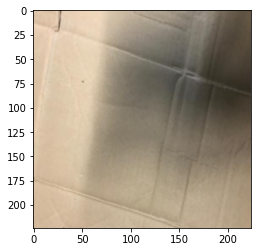

Label: paper , Predicted: paper


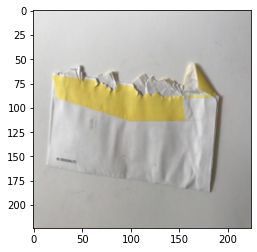

Label: glass , Predicted: glass


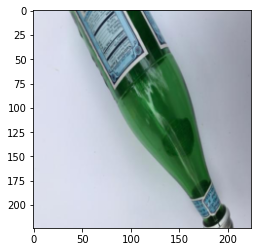

Label: cardboard , Predicted: cardboard


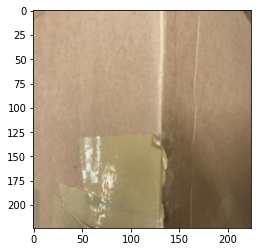

Label: cardboard , Predicted: cardboard


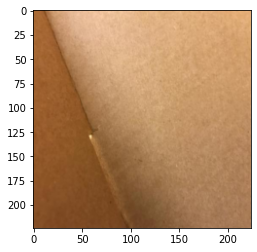

Label: glass , Predicted: glass


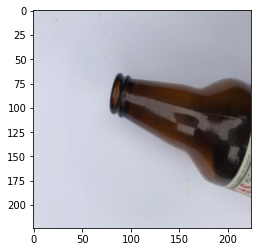

Label: glass , Predicted: glass


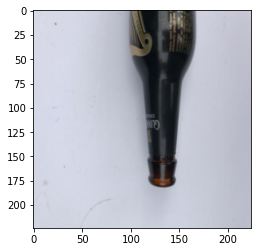

In [333]:
for i in range(11,20):
  img, label = test_ds[i]
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, googlenet))
  plt.imshow(img.permute(1, 2, 0))
  plt.show()